In [1]:
from typing import List
import torch
import pickle
import math
from collections import defaultdict, Counter
import numpy as np
from tqdm.auto import tqdm
import re
from matplotlib import pyplot as plt
from tqdm import tqdm

# будем использовать mpire для ускорения
# на некоторых системах есть проблема с кол-вом открываемвых
# файловы дескрипторов, поэтому разрешим нашему процессу
# создавать их в большЕм количестве
from mpire import WorkerPool
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

/home/ilya0100/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_CTC_DATASET_PATH = './test_data.pt'
VOCAB_PKL_PATH = './vocab.pkl'

In [3]:
dataset = torch.load(TEST_CTC_DATASET_PATH)
with open(VOCAB_PKL_PATH, 'rb') as fin:
    vocab_dict = pickle.load(fin)

# Часть 1. Метрики.

In [4]:
# поможем себе с расстоянием Левенштейна
import Levenshtein

# Будем использовать эту функцию для нормализации текстов перед замером CER / WER
ALLOWED_SYMBOLS = re.compile(r"(^[a-zа-я\s]+$)")
def normalize_text(text: str) -> str:
    """
    В датасетах, иногда встречается '-', 'ё', апострофы и большие буквы. А мы хотим, чтобы:
        WER("Ростов-на-дону", "ростов на дону") == 0
        WER("It's", "it s") == 0
        WER("ёлки палки", "елки палки") == 0
    Поэтому заменяем в target'ах 'ё' на 'е', а '-' на ' ' и т. д.
    Кроме того на всякий случай удаляем лишние пробелы.
    И проверяем что в получившейся строке только допустимые символы.
    """
    assert isinstance(text, str)
    text = text.lower().strip().replace("ё", "е")
    text = re.sub(r"\W+", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip().split(" ")
    text = " ".join(word for word in text if len(word) > 0)
    assert (text == "") or ALLOWED_SYMBOLS.match(text)
    return text

def wer(ground_truth: str, predicted: str) -> float:
    errors = Levenshtein.distance(ground_truth.split(), predicted.split())
    return errors

def cer(ground_truth: str, predicted: str) -> float:
    errors = Levenshtein.distance(ground_truth, predicted)
    return errors

# Функции для расчета relative CER / WER
# В функции нужно подавать строки обработанные методом normalize_text
def relative_cer(ground_truth: str, predicted: str) -> float:
    assert isinstance(ground_truth, str)
    assert isinstance(predicted, str)
    return min(1, cer(ground_truth, predicted) / (len(ground_truth) + 1e-10))

def relative_wer(ground_truth: str, predicted: str) -> float:
    assert isinstance(ground_truth, str)
    assert isinstance(predicted, str)
    gt_len = ground_truth.count(" ") + 1
    return min(1, wer(ground_truth, predicted) / (gt_len + 1e-10))

# Функции для расчета ORACLE relative CER / WER - тут мы выбираем лучшую гипотезу из beam'a
# В функции нужно подавать строки обработанные методом normalize_text
def oracle_relative_cer(ground_truth: str, predicted: List[str]) -> float:
    return min(relative_cer(ground_truth, hypo) for hypo in predicted)

def oracle_relative_wer(ground_truth: str, predicted: List[str]) -> float:
    return min(relative_wer(ground_truth, hypo) for hypo in predicted)

In [5]:
# Тесты для проверки правильности реализации cer/wer 
assert(cer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 6)
assert(wer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 2)

assert(cer(normalize_text(""), normalize_text("")) == 0)
assert(wer(normalize_text(""), normalize_text("")) == 0)

assert(cer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)
assert(wer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)

assert(cer(normalize_text("It's"), normalize_text("it s")) == 0)
assert(wer(normalize_text("It's"), normalize_text("it s")) == 0)

# Часть 2. CTC декодинг.

In [6]:
class CTCDecoder:
    
    def __init__(self, vocab_dict):
        self.vocab = vocab_dict
        
        # Id специальных токенов в словаре
        self.blank_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3
        self.word_sep_id = 4 
        # word_sep_id должен быть заменен на пробел при декодировании
        # и не забудьте удалить пробелы в конце строки!
        
    def argmax_decode(self, ctc_logits: torch.tensor) -> str:
        '''
        ctc_logits - ctc-матрица логитов размерности [TIME, VOCAB]
        '''
        ids = ctc_logits.max(-1)[1].squeeze().numpy()
        decoded = ""
        for i in range(len(ids) - 1):
            if ids[i] != ids[i + 1] and ids[i] != self.blank_id:
                if ids[i] == self.word_sep_id:
                    decoded += " "
                else:
                    decoded += self.vocab[ids[i]]
        return decoded.strip()
    
    def beam_search_decode(self, ctc_logits: torch.tensor, beam_size: int=16) -> List[str]:
        '''
        ctc_logits - ctc-матрица логитов размерности [TIME, VOCAB]
        beam_size - размер бима(луча)
        '''
        ctc_logits = torch.softmax(ctc_logits.squeeze(), dim=-1).numpy()
        ctc_logits = np.vstack((np.zeros(ctc_logits.shape[1]), ctc_logits))

        Pb, Pnb = defaultdict(Counter), defaultdict(Counter)
        Pb[0][""] = 1
        Pnb[0][""] = 0
        A_prev = [""]

        for t in range(1, ctc_logits.shape[0]):
            for l in A_prev:
                for c_idx, c in self.vocab.items():
                    if ctc_logits[t][c_idx] < 1e-4:
                        continue

                    if c_idx == self.blank_id:
                        Pb[t][l] += ctc_logits[t][c_idx] * (Pb[t - 1][l] + Pnb[t - 1][l])

                    else:
                        l_plus = l + c

                        if len(l) > 0 and c == l[-1]:
                            Pnb[t][l_plus] += ctc_logits[t][c_idx] * Pb[t - 1][l]
                            Pnb[t][l] += ctc_logits[t][c_idx] * Pnb[t - 1][l]

                        else:
                            Pnb[t][l_plus] += ctc_logits[t][c_idx] * (Pb[t - 1][l] + Pnb[t - 1][l])
                        
                        if l_plus not in A_prev:
                            Pb[t][l_plus] += ctc_logits[t][self.blank_id] * (Pb[t - 1][l_plus] + Pnb[t - 1][l_plus])
                            Pnb[t][l_plus] += ctc_logits[t][c_idx] * Pnb[t - 1][l_plus]

            A_next = Pb[t] + Pnb[t]
            sorter = lambda l: A_next[l]
            A_prev = sorted(A_next, key=sorter, reverse=True)[:beam_size]
        return [pred.replace("|", " ").strip() for pred in A_prev]

In [7]:
ctc_decoder = CTCDecoder(vocab_dict)

## <font color='red'>Внимание!</font> Далее ВЕЗДЕ используем только relative версии рассчета CER / WER и их oracle версии.

### Argmax декодинг.

In [8]:
# Рассчитаем усредненный по всему датасету relative CER / WER для ARGMAX варианта декодирования
cer_argmax = 0
wer_argmax = 0


for key, value in dataset.items():
    pred, true = value
    pred_str = ctc_decoder.argmax_decode(pred)
    cer_argmax += relative_cer(normalize_text(true), normalize_text(pred_str))
    wer_argmax += relative_wer(normalize_text(true), normalize_text(pred_str))

cer_argmax = cer_argmax / len(dataset)
wer_argmax = wer_argmax / len(dataset)

print(f"Mean CER in argmax decoding : {cer_argmax}")
print(f"Mean WER in argmax decoding : {wer_argmax}")

Mean CER in argmax decoding : 0.040561903129852875
Mean WER in argmax decoding : 0.15567387844386432


## Вопрос №1: Как соотносятся WER и CER в задаче ASR?

## Ответ: 
### - WER получился значительно больше т.к. слово считается неправильным даже если ошибка всего в одной букве

In [9]:
# Рассчитаем усредненный по всему датасету relative CER / WER для BEAM_SEARCH варианта декодирования
# Для рассчета используем beam_size = 1 !!!
# Hint : стоит использовать mpire для ускорения
cer_bs1 = 0
wer_bs1 = 0

for key, value in tqdm(dataset.items()):
    pred, true = value
    pred_str = ctc_decoder.beam_search_decode(pred, 1)
    cer_bs1 += relative_cer(normalize_text(true), normalize_text(pred_str[0]))
    wer_bs1 += relative_wer(normalize_text(true), normalize_text(pred_str[0]))

cer_bs1 = cer_bs1 / len(dataset)
wer_bs1 = wer_bs1 / len(dataset)

print(f"CER in bs decoding : {cer_bs1}")
print(f"WER in bs decoding : {wer_bs1}")

100%|██████████| 9630/9630 [00:42<00:00, 225.19it/s]

CER in bs decoding : 0.04066943741697979
WER in bs decoding : 0.15582372023702948


In [244]:
# Проверим, что мы нигде не ошиблись в написании кода beam_search_decode
np.testing.assert_almost_equal(cer_argmax, cer_bs1, decimal=4)
np.testing.assert_almost_equal(wer_argmax, wer_bs1, decimal=4)

In [245]:
# Ок, значит все хорошо и можно приступить к построению графиков
# зависимости усредненного CER / WER + oracle от beam_size.

# Для этого будем использовать beam_size = [4, 8, 16, 32].
# Заполним словарик усредненных по датасету relative wer / cer наиболее вероятной гипотезы - top1_wer, top1_cer.
# Так же добавим в словарик relative oracle wer / cer - orcale_wer, oracle_cer
graph_results = {'oracle_wer':[], 'oracle_cer':[], 'top1_wer':[], 'top1_cer': []}
beam_sizes = [4, 8 , 16, 32]
for beam_size in beam_sizes:
    top1_wer, top1_cer, oracle_wer, oracle_cer = 0, 0, 0, 0
    
    for key, value in tqdm(dataset.items()):
        pred, true = value
        pred_str = ctc_decoder.beam_search_decode(pred, beam_size)
        
        top1_cer += relative_cer(normalize_text(true), normalize_text(pred_str[0]))
        top1_wer += relative_wer(normalize_text(true), normalize_text(pred_str[0]))

        oracle_cer += oracle_relative_cer(normalize_text(true), [normalize_text(hypo) for hypo in pred_str])
        oracle_wer += oracle_relative_wer(normalize_text(true), [normalize_text(hypo) for hypo in pred_str])

    top1_cer = top1_cer / len(dataset)
    top1_wer = top1_wer / len(dataset)

    oracle_cer = oracle_cer / len(dataset)
    oracle_wer = oracle_wer / len(dataset)

    graph_results['top1_cer'].append(top1_cer)
    graph_results['top1_wer'].append(top1_wer)
    graph_results['oracle_cer'].append(oracle_cer)
    graph_results['oracle_wer'].append(oracle_wer)

100%|██████████| 9630/9630 [05:28<00:00, 29.35it/s]


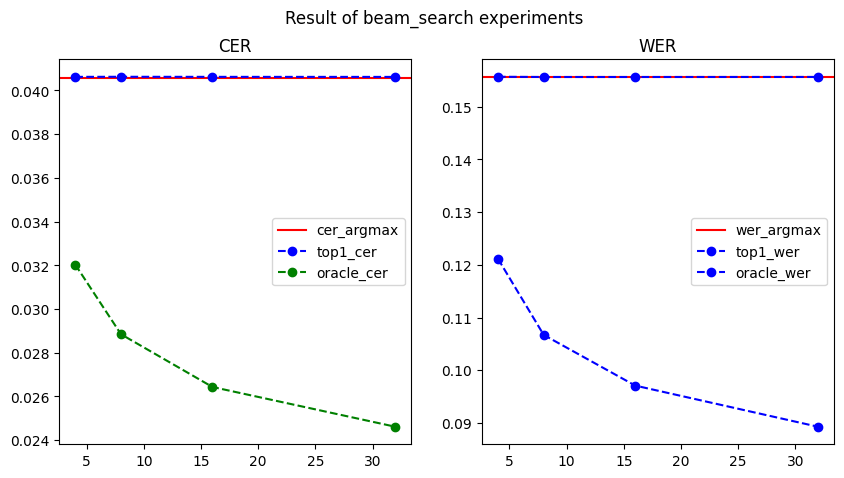

In [246]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Result of beam_search experiments')

axs[0].axhline(y = cer_argmax, color = 'r', linestyle = '-', label='cer_argmax')
axs[0].plot(beam_sizes, graph_results['top1_cer'], '--bo', label='top1_cer') 
axs[0].plot(beam_sizes, graph_results['oracle_cer'], '--go', label='oracle_cer')
axs[0].set_title('CER')
axs[0].legend()

axs[1].axhline(y = wer_argmax, color = 'r', linestyle = '-', label='wer_argmax')
axs[1].plot(beam_sizes, graph_results['top1_wer'], '--bo', label='top1_wer')
axs[1].plot(beam_sizes, graph_results['oracle_wer'], '--bo', label='oracle_wer')
axs[1].set_title('WER')
axs[1].legend()

## Вопрос №2: 
## - Сделайте выводы относительно поведения CER / WER при увеличении размера beam_size? 
## - Как соотносятся значения relative CER / WER и ORACLE варианты в beam_search ? 
## - Почему они так соотносятся ? 
## - Как можно улучшить beam search ?

## Ответ: 
### - CER / WER при увеличении размера beam_size не изменяются
### - 
### - 
### - beam search можно улучшить добавив языковую модель